# Lecture 20 - Performance Metrics

In [1]:
from scipy.stats import multivariate_normal
import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt
%matplotlib inline

## Example: GMM as Density Estimation

Consider some data generated from Scikit-Learn's ```make_moons``` function:

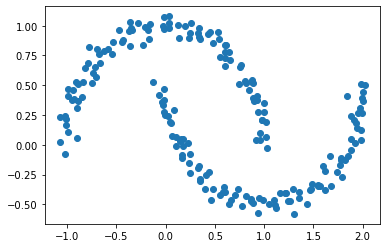

In [2]:
from sklearn.datasets import make_moons
from matplotlib.patches import Ellipse

Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

Let's create a helper function that will help us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output. 

* Let's not worry about the implementation of this helper function.

In [3]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

If we try to fit this with a two-component GMM viewed as a clustering model, the results are not particularly useful:

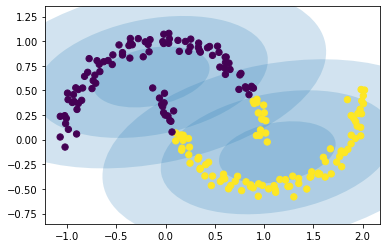

In [4]:
from sklearn.mixture import GaussianMixture

GMM = GaussianMixture(n_components=2, covariance_type='full', random_state=0).fit(Xmoon)
plot_gmm(GMM, Xmoon)

But if we instead use many more components and ignore the cluster labels, we find a fit that is much closer to the input data:

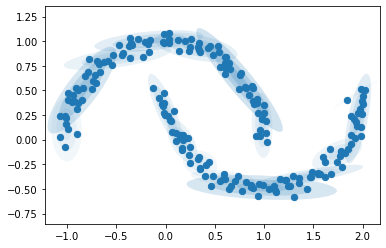

In [5]:
GMM16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0).fit(Xmoon)
plot_gmm(GMM16, Xmoon, label=False)

Here the mixture of 16 Gaussians serves not to find separated clusters of data, but rather to model the overall distribution of the input data. This is a generative model of the distribution, meaning that the GMM gives us the recipe to generate new random data distributed similarly to our input. 

For example, here are 400 new points drawn from this 16-component GMM fit to our original data:

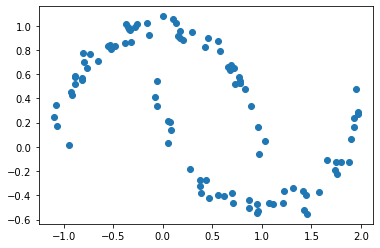

In [6]:
Xnew = GMM16.sample(100)
plt.scatter(Xnew[0][:, 0], Xnew[0][:, 1]);

GMM is convenient as a flexible means of modeling an arbitrary multi-dimensional distribution of data.

# Performance Metrics

A key step in machine learning algorithm development and testing is determining a good error and evaluation metric.

**Evaluation metrics** help us to estimate how well our model is trained and it is important to pick a metric that matches our overall goal for the system.

Some common evaluation metrics include precision, recall, receiver operating curves, and confusion matrices.

# Classification Accuracy and Error

Classification accuracy and e the number of correct predictions made as a ratio of all predictions made.

* **Classification accuracy** is defined as the number of correctly classified samples divided by all samples:

$$\text{accuracy} = \frac{N_{\text{corr}}}{N}$$

where $N_{\text{corr}}$ is the number of correct classified samples and $N$ is the total number of samples.

* **Classification error** is defined as the number of incorrectly classified samples divided by all samples:

$$\text{error} = \frac{N_{\text{miss}}}{N}$$

where $N_{\text{miss}}$ is the number of misclassified samples and $N$ is the total number of samples.

* Classification accuracy is the most common evaluation metric for classification problems, it is also the most misused. It is really only suitable when there are an equal number of observations in each class (which is rarely the case) and that all predictions and prediction errors are equally important, which is often not the case.

## Example 1: Fish Dataset
Suppose there is a 3-class classification problem, in which we would like to classify each training sample (a fish) to one of the three classes (A = salmon or B = sea bass or C = cod).

Let's assume there are 150 samples, including 30 salmon, 40 sea bass and 80 cod. Suppose our model misclassifies 4 salmon, 2 sea bass and 5 cod.

* The classification accuracy (ACC) of our binary classification model is calculated as:

$$\text{ACC} = \frac{26 + 38 + 75}{30 + 40 + 80} = \frac{139}{150} \approx 92.7 \%$$

* The prediction error is calculated as:

$$\text{error} = \frac{4 + 2 + 5}{30+40+80} = \frac{11}{150} \approx 7.3 \%$$


* The classification accuracy doesn't really gives an insight on which class is being misclassified the most.

# Confusion Matrix

A confusion matrix summarizes the classification accuracy across several classes. It shows the ways in which the classification model is confused when it makes predictions, allowing visualization of the performance of our algorithm. 

Generally, each row represents the instances of a actual class while each column represents the instances in an predicted class.

If the classifier is trained to distinguish between salmon, sea bass and cod. We can summarize the prediction result in the confusion matrix as follows:

|actual/predict|    salmon    |    sea bass  |      cod     |
|--------------|--------------|--------------|--------------|
|    salmon    |      26      |       2      |       2      |
|    sea bass  |       2      |       38     |       0      |
|      cod     |       2      |       3      |       75     |


In this confusion matrix, of the 30 salmons (row 1), the classifier predicted that 26 are labeled salmon correctly, 2 are wrongly labeled as sea bass, and another 2 are wrongly labeled as cod. 

All correct predictions are located in the diagonal of the table. So it is easy to visually inspect the table for prediction errors, as they will be represented by values outside the diagonal.

# Precision, Recall & Fall-Out

We are often looking to discriminate between observations with a specific binary outcome, for example, event or no event. In our example, the fish company would like to produce salmon can but the harvest contains all three species. In this way,
we can assign the event (salmon) as "positive" and no-event (not salmon) as "negative".

The confusion matrix for this two-class classification problem is:

|actual/predict|    salmon    |  non-salmon  |
|--------------|--------------|--------------|
|    salmon    |      26      |       4      |
|  non-salmon  |       4      |      116     |

* **True positive (TP):** correctly predicting positive events
* **False positive (FP):** incorrectly calling positive to a negative event
* **True negative (TN):** correctly predicting negative events
* **False negative (FN):** incorrectly labeling negative to a positive event

*In this salmon/non-salmon classification problem, what are the TP, FP, TN, FN values?*

|actual/predict|   Positive   |   Negative   |
|--------------|--------------|--------------|
|   Positive   |      TP      |      FN      |
|   Negative   |      FP      |      TN      |

* **Precision**, also called Positive Predictive Value (PPV), is the performance of detection

$$\text{Precision} = \text{PPV} = \frac{TP}{TP + FP}$$

* **Recall**, also called True Positive Rate (TPR) or Sensitivity, is the probability of detection

$$\text{Recall} = \text{TPR} = \text{Sensitivity} = \frac{TP}{TP + FN}$$

* **Fall-out**, also called False Positive Rate (FPR), is the probability of false alarm

$$\text{Fall-out} = \text{FPR} = \frac{FP}{FP + TN}$$

* **Specificity**, also called True Negative Rate (TNR), is the probability of negative events detection

$$\text{Specificity} = \frac{TN}{TN + FP}$$

<!--* **F1-score**, also called F-score or F-measure, is a measure of a model's accuracy. It considers both the precision and the recall-->

<!--$$\text{F1-score} = 2\times\frac{\text{Precision}\times \text{Recall}}{\text{Precision} + \text{Recall}}$$-->

* Learn about many other measures on the [Wikipedia page](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) and [Scikit-Learn Metrics Module](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

# ROC Curves

**Receiver Operating Characteristic (ROC) curve** is the plot between the true positive rate (TPR) and the false positive rate (FPR), where the TPR is defined as the y-axis and FPR is defined as the x-axis.

* ROC curves were first developed for RADAR systems, hence the name.

* Given a binary classifier and its threshold, the (x,y) coordinates of ROC space can be calculated from all the prediction result. You trace out a ROC curve by varying the threshold to get all of the points on the ROC.

* The diagonal between (0,0) and (1,1) separates the ROC space into two areas, which are left up area and right bottom area. The points above the diagonal represent good classification (better than random guess) which below the diagonal represent bad classification (worse than random guess).

* *What is the perfect prediction point in a ROC curve?*


## Area Under the Curve (AUC)

**Area Under Curve (AUC)** is a common measure of how good a test is. It is simply the area under the ROC curve. Random guessing can achieve the diagonal line, so the minimum AUC is 1/2. The maximum AUC is 1, which is achieved by a test that is always right; the ROC curve is along the left and top axes.

## Example

1. Suppose you have a target detection task that you would like to evaluate using ROC curve analysis. You emplaced 10 targets and collected aerial hyperspectral imagery over 10 $km^2$. Then, suppose you ran a set of alarm generation and target detection algorithms over the collected data. Your algorithms produced the following list of alarm confidence values. You have already matched each of these alarms to a location on the ground and compared them with you ground truth. True targets, based on your ground truth, are marked with a "T" in the second column. Draw the associated ROC cure for these results.

Alarm confidence values |  0.91  |  0.90  |  0.80  |  0.79  |  0.77  |  0.75  |  0.50  |  0.40  |  0.39  |  0.38  |  0.37  |  0.25  |  0.10  |  0.09  |  0.01  |
------------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
    Ground truth        |   T    |   T    |        |   T    |        |        |        |   T    |        |        |        |        |        |   T    |        |


2. Suppose you were segmenting a data set into three classes (e.g., vegetation, man-made materials, sand) and wanted to evaluate your results. Would using a ROC curve be an appropriate method for evaluation? Why or why not?